In [1]:
import os
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch.nn.functional as F

from torchmetrics import Accuracy, F1Score ,CohenKappa

from dretino.dataloader.build_features import DRDataModule
from dretino.models.mseloss import ModelMSE
from dretino.models.train_model import Model, train
from dretino.visualization.visualize import show_images, cal_mean, plot_metrics

In [2]:
PATH = '../data/processed/'

dfx = pd.read_csv(PATH + '2.Groundtruths/a.IDRiD_Disease_Grading_Training_Labels.csv',usecols = ['Image name','Retinopathy grade'])
df_test = pd.read_csv(PATH + '2.Groundtruths/b.IDRiD_Disease_Grading_Testing_Labels.csv',usecols = ['Image name','Retinopathy grade'])

dfx.head()

,Image name,Retinopathy grade
0,IDRiD_001,3
1,IDRiD_002,3
2,IDRiD_003,2
3,IDRiD_004,3
4,IDRiD_005,4


In [3]:
df_train, df_valid = train_test_split(
        dfx,
        test_size=0.1, 
        random_state=42, 
        stratify=dfx['Retinopathy grade'].values
    )

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

df_train.head()

,Image name,Retinopathy grade
0,IDRiD_234,0
1,IDRiD_212,0
2,IDRiD_269,3
3,IDRiD_268,0
4,IDRiD_005,4


In [4]:
train_transforms = A.Compose(
    [
        A.Resize(width=250, height=250),
        A.RandomCrop(height=224, width=224),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(height=224, width=224),
        A.Normalize(
            mean=(0.5237, 0.2542, 0.0853),
            std=(0.2649, 0.1497, 0.0876),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

C:\Users\dines\anaconda3\envs\PytorchLightning\lib\site-packages\pytorch_lightning\core\datamodule.py:121: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
100%|██████████| 371/371 [00:57<00:00,  6.44it/s]
C:\Users\dines\anaconda3\envs\PytorchLightning\lib\site-packages\pytorch_lightning\core\datamodule.py:114: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


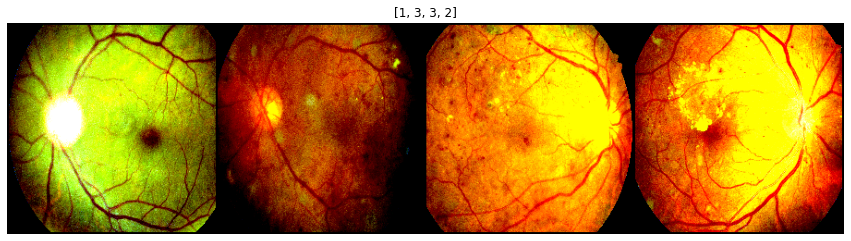

In [5]:
dm = DRDataModule(df_train, df_valid, df_test,
                      train_path=PATH + 'images_resized',
                      valid_path=PATH + 'images_resized',
                      test_path=PATH + 'test_images_resized',
                      train_transforms=train_transforms,
                      val_transforms=val_transforms,
                      test_transforms=test_transforms,
                      num_workers=4,
                      batch_size=4)

show_images(dm.train_dataloader())

In [6]:
model = ModelMSE(model_name='resnet50d',
                 num_classes=5,
                 additional_layers=False)

print(model)

ModelMSE(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [9]:
def train_one_epoch(model,dataloader,optimizer,loss_fn):
    loss_ = 0
    acc_ = []
    f1_ = []
    kappa_ = []
    for idx,(x,y) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        y = torch.argmax(y,dim=-1)
        y = torch.unsqueeze(y,1).to(torch.float32)
        logits = model(x)
        loss = loss_fn(y,logits)
        loss_+=loss.item()
        loss.backward()
        optimizer.step()
        predictions = logits.data
        predictions[predictions < 0.5] = 0
        predictions[(predictions >= 0.5) & (predictions < 1.5)] = 1
        predictions[(predictions >= 1.5) & (predictions < 2.5)] = 2
        predictions[(predictions >= 2.5) & (predictions < 3.5)] = 3
        predictions[(predictions >= 3.5) & (predictions < 1000000000000)] = 4
        preds = predictions.long().view(-1)
        acc_.append(accuracy(preds, y.to(torch.int16).view(-1)))
        f1_.append(metric(preds, y.to(torch.int16).view(-1)))
        kappa_.append(kappametric(preds, y.to(torch.int16).view(-1)))
    print(f"loss : {loss_/idx}\n",
          f"acc :  {np.array(acc_).mean()}\n",
          f"f1 :  {np.array(f1_).mean()}\n",
          f"kappa :  {np.array(kappa_).mean()}")


In [10]:
accuracy = Accuracy()
metric = F1Score(num_classes=5)
kappametric = CohenKappa(num_classes=5)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
loss_fn = nn.MSELoss()

train_one_epoch(model,dm.train_dataloader(),optimizer,loss_fn)

93it [03:52,  2.50s/it]

loss : 1.5479549125808736
 acc :  0.33691757917404175
 f1 :  0.33691757917404175
 kappa :  0.15585918724536896
